# Notebook to make Fig. 1

In [0]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd
import lal
from scipy.stats import gaussian_kde
import importlib

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D

import seaborn as sns
cp = sns.color_palette('colorblind')
cp2 = sns.color_palette('pastel')

from helper_functions import *

import sys
sys.path.append('../utils')
import reconstructwf as rwf

style.use('plotting.mplstyle')

### Load in data: posteriors

Load in posterior and prior samples

In [1]:
data_dir = '/Users/smiller/Documents/gw190521-timedomain-release/data_simonas_laptop/' 

date = '063023'

tcutoffs = ['m50M', 'm40M', 'm37.5M', 'm35M', 'm32.5M', 'm30M', 'm27.5M', 'm25M', 'm22.5M', 'm20M', 
                'm17.5M', 'm15M', 'm12.5M', 'm10M', 'm7.5M', 'm5M', 'm2.5M', '0M', '2.5M', '5M', '7.5M', 
                '10M', '12.5M', '15M', '17.5M', '20M', '30M', '40M', '50M']

td_samples = load_posterior_samples(data_dir, date, tcutoffs)[0]

Generate KDE for $\chi_\mathrm{p}$ from the full run and the prior, for comparison 

In [2]:
# kde for full run 
samples_full = td_samples['full']
m1_full, m2_full = m1m2_from_mtotq(samples_full['mtotal'], samples_full['q'])
chip_full_samples = chi_precessing(m1_full, samples_full['chi1'], samples_full['tilt1'],
                          m2_full, samples_full['chi2'], samples_full['tilt2'])

chip_grid, chip_full_kde_on_grid = reflected_kde(chip_full_samples, 0, 1)

# kde for prior 
samples_prior = td_samples['prior']
m1_prior, m2_prior = m1m2_from_mtotq(samples_prior['mtotal'], samples_prior['q'])
chip_prior_samples = chi_precessing(m1_prior, samples_prior['chi1'], samples_prior['tilt1'],
                          m2_prior, samples_prior['chi2'], samples_prior['tilt2'])

_, chip_prior_kde_on_grid = reflected_kde(chip_prior_samples, 0, 1)

### Load in data: strain timeseries

Load in time-domain data from the detectors

In [3]:
data_dict =  np.load(data_dir+'LVC_strain_data.npy', allow_pickle=True).item()
wh_data_dict =  np.load(data_dir+'LVC_strain_data_whitened.npy', allow_pickle=True).item()
time_dict_data =  np.load(data_dir+'LVC_time_data.npy', allow_pickle=True).item()

Load in reconstructions from before/after each cutoff time

In [4]:
reconstruction_dict = np.load(data_dir+"waveform_reconstructions_L1.npy",allow_pickle=True).item()

Define cutoff times 

In [5]:
# 0M <-> seconds
t0_0M_dict = {}
t0_0M_geo = 1242442967.405764
dt_10M = 0.0127 # 10 M = 12.7 ms 
dt_1M = dt_10M/10.

tstart = 1242442966.9077148
tend = 1242442967.607715
ra = 6.07546535866838
dec = -0.8000357325337637

# define t_0M in each detector in seconds
for ifo in ['H1', 'L1', 'V1']: 
    
    t_delay = lal.TimeDelayFromEarthCenter(lal.cached_detector_by_prefix[ifo].location, ra, dec, t0_0M_geo)
    t0_0M_dict[ifo] = t0_0M_geo + t_delay
    
# Max P strain from full run
lnL = reconstruction_dict['full']['params']['ln_posterior'] - reconstruction_dict['full']['params']['ln_prior']
i_maxL = np.argmax(lnL)
L1_maxL_strain = np.asarray(reconstruction_dict['full']['h'][i_maxL])
L1_maxL_strain_wh = np.asarray(reconstruction_dict['full']['wh'][i_maxL])
L1_maxL_strain_bp = np.asarray(reconstruction_dict['full']['bp'][i_maxL])

# L1 strain
L1_LVC_strain = data_dict['L1']
L1_LVC_strain_wh = wh_data_dict['L1']
L1_LVC_strain_bp = rwf.bandpass(L1_LVC_strain, time_dict_data['L1'], 20, 500)

# Transform timeseries into into units of M
reconstruction_times_M = (reconstruction_dict['time samples']- t0_0M_dict['L1'])/dt_1M
L1_times_M = (time_dict_data['L1'] - t0_0M_dict['L1'])/dt_1M

Print some maxL parameters from full IMR run:

In [6]:
maxL_params = reconstruction_dict['full']['params'][i_maxL]

m1_maxL, m2_maxL = m1m2_from_mtotq(maxL_params['mtotal'], maxL_params['q'])
chip_maxL = chi_precessing(m1_maxL, maxL_params['chi1'], maxL_params['tilt1'], 
                           m2_maxL, maxL_params['chi2'], maxL_params['tilt2'])

print('max P chi_p = ', chip_maxL)
print('max P mtotal = ', maxL_params['mtotal'])
print('max P q = ',  maxL_params['q'])

max P chi_p =  0.9242539211478511
max P mtotal =  266.9549729649809
max P q =  0.831889425498406


### Make figure

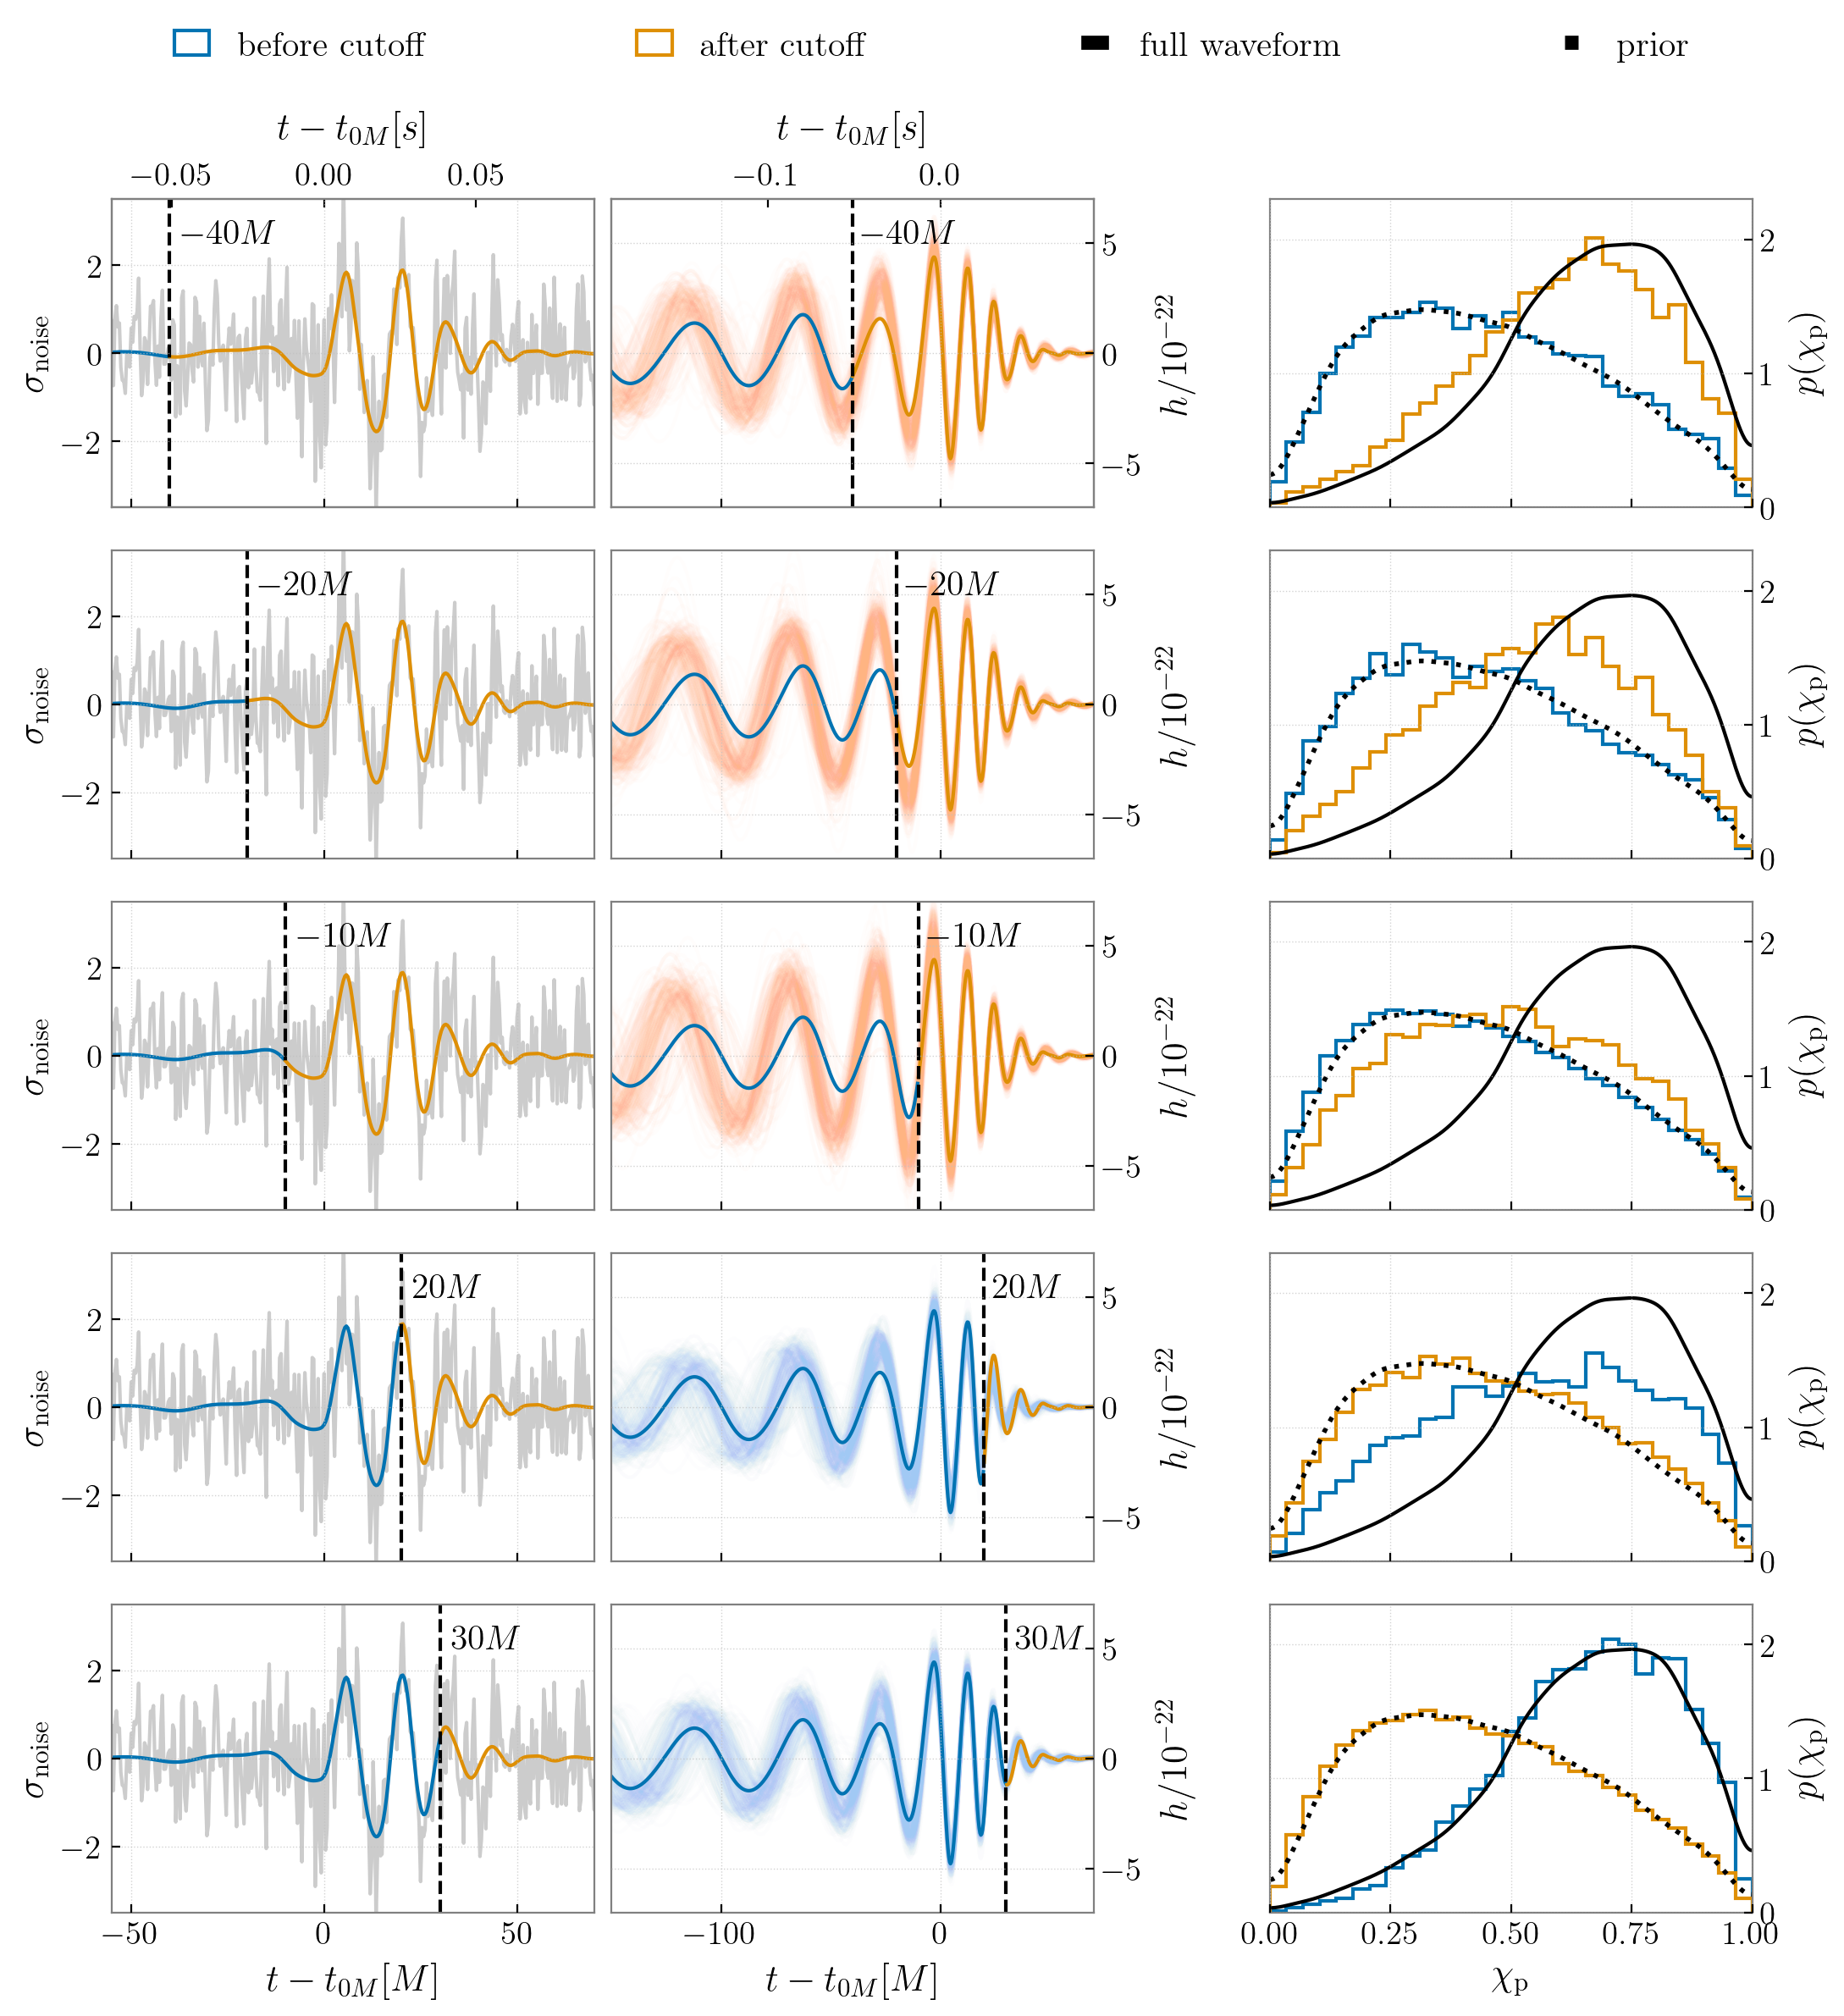

In [7]:
# Define times to plot
tc_to_plot = ['m40M', 'm20M', 'm10M', '20M', '30M']
n_to_plot = len(tc_to_plot)

# Cast strings to floats
tc_floats = []
for tc_str in tc_to_plot:
    if tc_str[0]=='m':
        tc_str_trimmed = tc_str[1:-1]
    else:
        tc_str_trimmed = tc_str[0:-1]     
    tc_float = -1*float(tc_str_trimmed) if tc_str[0]=='m' else float(tc_str_trimmed) 
    tc_floats.append(tc_float)

# Make figure 
fig, axes = plt.subplots(n_to_plot, 3, figsize=(15/1.2, 25*n_to_plot/8/1.2))

for j,tc in enumerate(tc_floats):
    
    # Lefthand plots: whitened waveforms with cutoff
    x_lims_left = [-55, 70]
    if j==0:
        top_ax = axes[j][0].twiny()
        top_ax.plot(L1_times_M*dt_1M, L1_LVC_strain_wh, color='k', alpha=0.2)
        top_ax.set_xlabel(r'$t-t_{0M} [s] $', fontsize=16, labelpad=10)
        top_ax.set_xlim(x_lims_left[0]*dt_1M, x_lims_left[1]*dt_1M)
        top_ax.grid(visible=False)
        top_ax.set_zorder(axes[j][0].get_zorder()-1) # make this under what will be plotted after
        axes[j][0].patch.set_visible(False)
    else:
        axes[j][0].plot(L1_times_M, L1_LVC_strain_wh, color='k', alpha=0.2)
        
    mask = reconstruction_times_M<tc
    axes[j][0].plot(reconstruction_times_M[mask], L1_maxL_strain_wh[mask], color=cp[0])
    axes[j][0].plot(reconstruction_times_M[~mask], L1_maxL_strain_wh[~mask], color=cp[1])
    axes[j][0].axvline(tc, ls='--', color='k')
    
    tc_str = tc_to_plot[j]
    lbl = tc_str.replace('m', '-') if tc_str[0]=='m' else tc_str
    axes[j][0].text(tc+3, 2.5, f'${lbl}$', color='k', fontsize=15)
    
    if j!=n_to_plot-1: 
        axes[j][0].set_xticklabels([])
    else: 
        axes[j][0].set_xlabel(r'$t-t_{0M} [M]$', fontsize=16)
    axes[j][0].set_ylabel(r'$\sigma_\mathrm{noise}$', fontsize=16)
    axes[j][0].grid(color='silver', ls=':', alpha=0.7)
    axes[j][0].set_xlim(*x_lims_left)
    axes[j][0].set_ylim(-3.5, 3.5)
        
    
    # Middle plots: bandpassed waveforms with cutoff
    x_lims_center = [-150, 70]
    if j==0:
        top_ax = axes[j][1].twiny()
        top_ax.plot(L1_times_M*dt_1M, L1_LVC_strain/(1e-22), color='k', alpha=0)
        top_ax.set_xlabel(r'$t-t_{0M} [s] $', fontsize=16, labelpad=10)
        top_ax.set_xlim(x_lims_center[0]*dt_1M, x_lims_center[1]*dt_1M)
        top_ax.grid(visible=False)
        top_ax.set_zorder(axes[j][0].get_zorder()-1) # make this under what will be plotted after
        axes[j][1].patch.set_visible(False)
        
    else:
        axes[j][1].plot(L1_times_M, L1_LVC_strain/(1e-22), color='k', alpha=0)
        
    axes[j][1].plot(reconstruction_times_M[mask], L1_maxL_strain[mask]/(1e-22), color=cp[0])
    axes[j][1].plot(reconstruction_times_M[~mask], L1_maxL_strain[~mask]/(1e-22), color=cp[1])
    axes[j][1].axvline(tc, ls='--', color='k')
    
    if j!=n_to_plot-1: 
        axes[j][1].set_xticklabels([])
    else: 
        axes[j][1].set_xlabel(r'$t-t_{0M} [M]$', fontsize=16)
        
    # Plot reconstructions before/after the cutoff
    n_reconstruction_to_plot = 300
    alpha_reconstruct = 0.02
    if tc>0:
        reconstructions = np.asarray(reconstruction_dict[f'insp {tc_str}']['h'])
        idxs_to_plot = np.random.choice(reconstructions.shape[0], size=n_reconstruction_to_plot)
        axes[j][1].plot(reconstruction_times_M, np.transpose(reconstructions[idxs_to_plot,:])/(1e-22), 
                        color=cp2[0], alpha=alpha_reconstruct, zorder=0)
    else:
        reconstructions = np.asarray(reconstruction_dict[f'rd {tc_str}']['h'])
        idxs_to_plot = np.random.choice(reconstructions.shape[0], size=n_reconstruction_to_plot)
        axes[j][1].plot(reconstruction_times_M, np.transpose(reconstructions[idxs_to_plot,:])/(1e-22), 
                        color=cp2[1], alpha=alpha_reconstruct, zorder=0)
    
    axes[j][1].set_ylabel(r'$h/10^{-22}$', fontsize=16)
    axes[j][1].grid(color='silver', ls=':', alpha=0.7)
    axes[j][1].set_xlim(*x_lims_center)
    axes[j][1].set_ylim(-7, 7)
    axes[j][1].text(tc+4, 5, f'${lbl}$', color='k', fontsize=15)
    
    axes[j][1].yaxis.set_label_position("right")
    axes[j][1].yaxis.tick_right()
    
    x0, y0, x1, y1 = axes[j][1].get_position().bounds
    axes[j][1].set_position([x0-0.0375, y0, x1, y1])
    
    # Righthand plots: chi_p posteriors
    try:
        samples_insp = td_samples[f'insp {tc_str}']
        m1_insp, m2_insp = m1m2_from_mtotq(samples_insp['mtotal'], samples_insp['q'])
        chip_insp = chi_precessing(m1_insp, samples_insp['chi1'], samples_insp['tilt1'], 
                                   m2_insp, samples_insp['chi2'], samples_insp['tilt2'])
    except: 
        samples_insp = td_samples['prior']
        mask = np.random.choice(len(samples_insp), size=len(td_samples[f'rd {tc_str}']))
        m1_insp, m2_insp = m1m2_from_mtotq(samples_insp['mtotal'][mask], samples_insp['q'][mask])
        chip_insp = chi_precessing(m1_insp, samples_insp['chi1'][mask], samples_insp['tilt1'][mask], 
                                   m2_insp, samples_insp['chi2'][mask], samples_insp['tilt2'][mask])
    
    samples_rd = td_samples[f'rd {tc_str}']
    m1_rd, m2_rd = m1m2_from_mtotq(samples_rd['mtotal'], samples_rd['q'])
    chip_rd = chi_precessing(m1_rd, samples_rd['chi1'], samples_rd['tilt1'],
                                m2_rd, samples_rd['chi2'], samples_rd['tilt2'])
    
    axes[j][2].hist(chip_insp, histtype='step', bins=np.linspace(0,1,30), lw=1.5, 
                    color=cp[0], label='before cutoff', density=True)
    axes[j][2].hist(chip_rd, histtype='step', bins=np.linspace(0,1,30), lw=1.5, color=cp[1], 
                    label='after cutoff', density=True)
    
    axes[j][2].plot(chip_grid, chip_full_kde_on_grid, color='k', label='full waveform')
    axes[j][2].plot(chip_grid, chip_prior_kde_on_grid, color='k', ls=':', lw=2, label='prior')
    
    axes[j][2].yaxis.set_label_position("right")
    axes[j][2].set_ylabel(r'$p(\chi_\mathrm{p})$', fontsize=16)
    axes[j][2].yaxis.tick_right()
    if j!=n_to_plot-1: 
        axes[j][2].set_xticklabels([])
    else: 
        axes[j][2].set_xlabel(r'$\chi_\mathrm{p}$', fontsize=16)
    axes[j][2].set_xlim(0,1)
    axes[j][2].set_ylim(0,2.3)
    axes[j][2].grid(color='silver', ls=':', alpha=0.7)
    
for ax in axes: 
    for a in ax:
        x0, y0, x1, y1 = a.get_position().bounds
        a.set_position([x0, y0, x1, y1+0.035/n_to_plot])

axes[0][2].legend(bbox_to_anchor=(-2.3, 1.4, 3.2, .102), loc='lower left',
                      ncols=4, mode="expand", borderaxespad=0., frameon=False, fontsize=15)

plt.savefig('figure_01.pdf', bbox_inches='tight')
plt.show()